In [1]:
import torch
import torchvision.transforms as T
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import math
from ignite.engine import Engine
from ignite.metrics import SSIM

c:\Users\vuduy\AppData\Local\Programs\Python\Python310\lib\site-packages\ignite\handlers\checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


In [2]:
class FSRCNN(nn.Module):
    def __init__(self, scale_factor=2):
        super(FSRCNN, self).__init__()
        self.scale_factor = scale_factor
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 56, kernel_size=5, padding=5//2),
                        nn.PReLU(56))
        self.conv2 = nn.Sequential(
                        nn.Conv2d(56, 12, kernel_size=1, padding=0),
                        nn.PReLU(12))
        self.conv3_1 = nn.Sequential(
                        nn.Conv2d(12, 12, kernel_size=3, padding=3//2),
                        nn.PReLU(12))
        self.conv3_2 = nn.Sequential(
                        nn.Conv2d(12, 12, kernel_size=3, padding=3//2),
                        nn.PReLU(12))
        self.conv3_3 = nn.Sequential(
                        nn.Conv2d(12, 12, kernel_size=3, padding=3//2),
                        nn.PReLU(12))
        self.conv3_4 = nn.Sequential(
                        nn.Conv2d(12, 12, kernel_size=3, padding=3//2),
                        nn.PReLU(12))
        self.conv4 = nn.Sequential(
                        nn.Conv2d(12, 56, kernel_size=1, padding=0),
                        nn.PReLU(56))
        self.conv5 = nn.ConvTranspose2d(56, 3, kernel_size=9, stride=scale_factor, padding=9//2, output_padding=scale_factor-1)
        self._initialize_weights()
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3_1(x)
        x = self.conv3_2(x)
        x = self.conv3_3(x)
        x = self.conv3_4(x)
        x = self.conv4(x)
        x = self.conv5(x)
        return x
    def _initialize_weights(self) -> None:
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight.data, mean=0.0, std=math.sqrt(2 / (m.out_channels * m.weight.data[0][0].numel())))
                nn.init.zeros_(m.bias.data)

            elif isinstance(m, nn.ConvTranspose2d):
                nn.init.normal_(m.weight.data, mean=0.0, std=0.001)
                nn.init.zeros_(m.bias.data)

In [3]:
def preprocess_image(image_path):
    # Mở ảnh từ file
    image = Image.open(image_path).convert("RGB")
    # Biến đổi: Resize ảnh đầu vào thành Low-Resolution (LR)
    transform_lr = T.ToTensor()  # Dùng để chuyển ảnh gốc thành tensor
    # Ảnh đầu vào (Low-Resolution)
    lr_image = transform_lr(image)
    # Thêm batch dimension: (B, C, H, W)
    lr_image = lr_image.unsqueeze(0)
    return lr_image

In [7]:
def display_images(input_image, output_image):
    """Hiển thị ảnh đầu vào, ảnh đầu ra, và ảnh gốc."""
    fig, axes = plt.subplots(1, 2, figsize=(20, 20))
    axes[0].imshow(input_image.permute(1, 2, 0).cpu().numpy())
    axes[0].set_title("Low-Resolution (Input)")
    axes[0].axis("off")
    
    axes[1].imshow(output_image.permute(1, 2, 0).cpu().detach().numpy())
    axes[1].set_title("Super-Resolution (Output2)")
    axes[1].axis("off")
    
    plt.show()

In [5]:
# Đường dẫn tới file model đã được huấn luyện
pretrained_model_path = "fsrcnn_trained_model_scale_4.pth"
scale_factor = 4   # Scale factor
# Khởi tạo mô hình FSRCNN
model = FSRCNN(scale_factor=scale_factor)  # Chọn scale_factor giống với lúc huấn luyện
# Load trọng số đã huấn luyện
model.load_state_dict(torch.load(pretrained_model_path))
# Chuyển mô hình sang chế độ đánh giá (evaluation)
model.eval()

C:\Users\vuduy\AppData\Local\Temp\ipykernel_34476\709022453.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pretrained_model_path))


FSRCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 56, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): PReLU(num_parameters=56)
  )
  (conv2): Sequential(
    (0): Conv2d(56, 12, kernel_size=(1, 1), stride=(1, 1))
    (1): PReLU(num_parameters=12)
  )
  (conv3_1): Sequential(
    (0): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): PReLU(num_parameters=12)
  )
  (conv3_2): Sequential(
    (0): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): PReLU(num_parameters=12)
  )
  (conv3_3): Sequential(
    (0): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): PReLU(num_parameters=12)
  )
  (conv3_4): Sequential(
    (0): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): PReLU(num_parameters=12)
  )
  (conv4): Sequential(
    (0): Conv2d(12, 56, kernel_size=(1, 1), stride=(1, 1))
    (1): PReLU(num_parameters=56)
  )
  (conv5): ConvTranspose2d(56, 3, kernel_size=(9, 9), stride=(4, 

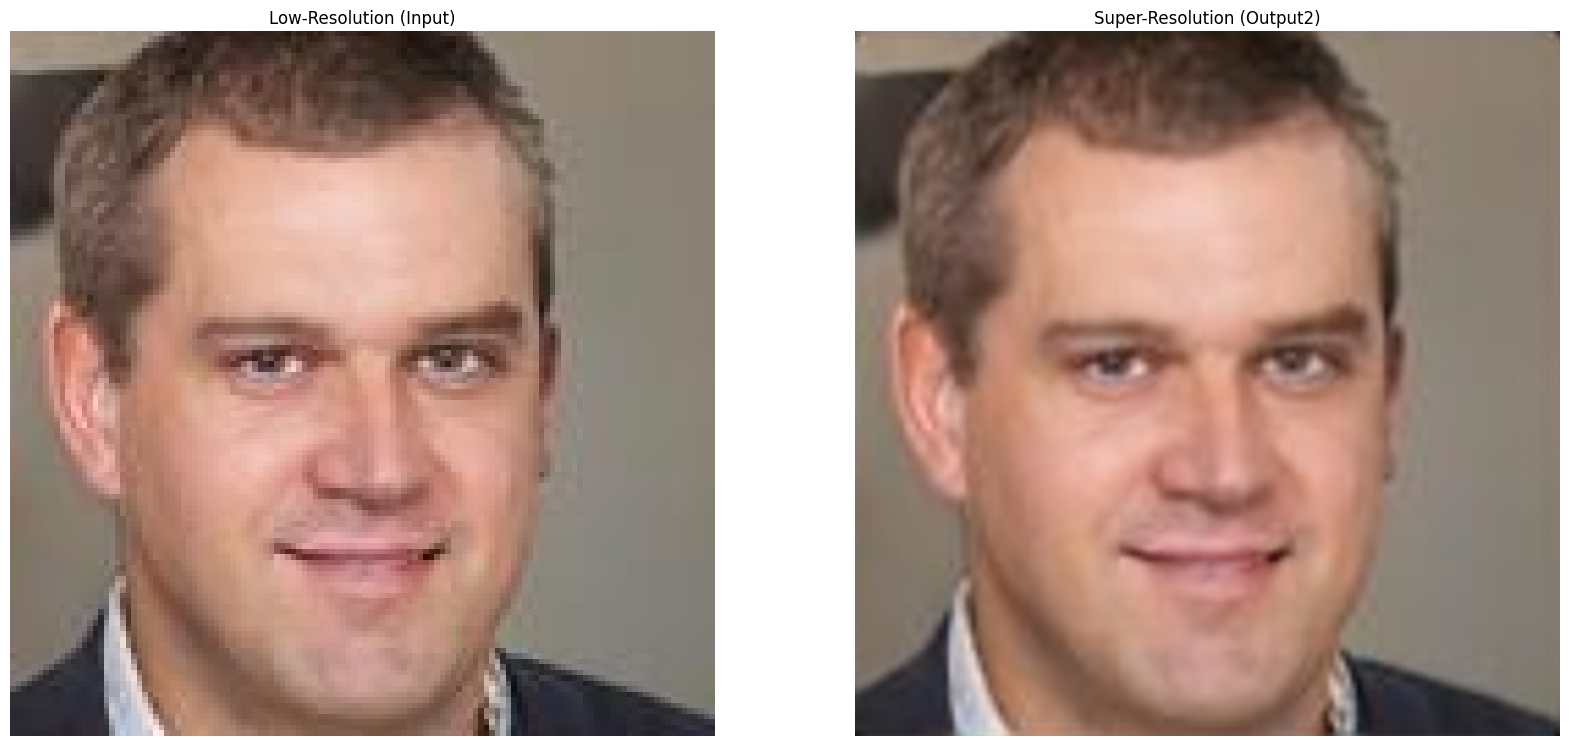

In [ ]:
# Với Scale Factor = 4
image_path = "dataset/downscale_img/downscaled_t60.png"
# Tiền xử lý ảnh
lr_image = preprocess_image(image_path)

# Dự đoán ảnh siêu phân giải
with torch.no_grad():
    sr_image = model(lr_image)  # Dự đoán
    sr_image_1 = model(sr_image)
    sr_image_output = torch.clamp(sr_image_1, 0, 1)  # Đảm bảo giá trị pixel hợp lệ

display_images(lr_image[0], sr_image_output[0])